In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import emoji
from matplotlib import pyplot as plt
import math
from joblib import dump, load

stop_words = set(stopwords.words("english"))


In [66]:
fn = "group_8_automotive_data.csv"
data = pd.read_csv(fn, encoding='utf-8')

In [4]:
# from nltk.corpus import wordnet

# def negate(sentence):	
#   '''
#   Input: Tokenized sentence (List of words)
#   Output: Tokenized sentence with negation handled (List of words)
#   '''
#   temp = int(0)
#   for i in range(len(sentence)):
#       if sentence[i-1] in ['not',"n't"]:
#           antonyms = []
#           for syn in wordnet.synsets(sentence[i]):
#               syns = wordnet.synsets(sentence[i])
#               w1 = syns[0].name()
#               temp = 0
#               for l in syn.lemmas():
#                   if l.antonyms():
#                       antonyms.append(l.antonyms()[0].name())
#               max_dissimilarity = 0
#               for ant in antonyms:
#                   syns = wordnet.synsets(ant)
#                   w2 = syns[0].name()
#                   syns = wordnet.synsets(sentence[i])
#                   w1 = syns[0].name()
#                   word1 = wordnet.synset(w1)
#                   word2 = wordnet.synset(w2)
#                   if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
#                       temp = 1 - word1.wup_similarity(word2)
#                   if temp>max_dissimilarity:
#                       max_dissimilarity = temp
#                       antonym_max = ant
#                       sentence[i] = antonym_max
#                       sentence[i-1] = ''
#   while '' in sentence:
#       sentence.remove('')
#   return sentence

# negate(["not", "good"])

In [54]:
Df_nans = data.loc[data["product_title"].isna()]
len(Df_nans)
data.loc[data["product_title"].isna(), "product_title"] = ""

In [4]:
#Snellere negatie code, Corret-negatie code

def negate(value):
    result = []
    i = 0
    while i < len(value):
        if i < len(value) - 1 and value[i] in ["not", "no"]:
            result.append(("not " + value[i + 1]).strip())
            i += 2
        else:
            result.append(value[i])
            i += 1
    return result

In [5]:
def cleanly_tokenize(text):
  # Remove URLs
  text = re.sub(r"http\S+|www\S+|https\S+", "", text)
  
  # Remove HTML tags by getting parsed text
  text = BeautifulSoup(text, "html.parser").get_text()

  # Replace Markdown-like
  text = re.sub(r"\[\[.*\]\]", "", text)

  # Replace "n't" with " not"
  text = re.sub(r"n't", " not", text)

  # Remove non-letters (except emojis) and lowercase 
  pattern = r'[^a-zA-Z0-9\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+'
  text = re.sub(pattern, " ", text).lower()
  
  # Replace emojis with text representation
  text = emoji.demojize(text, [" emoji_", " "])

  # Tokenize
  tokens = word_tokenize(text)

  # Remove stopwords
  tokens = [i for i in tokens if i not in stop_words or i in ["not"]]
  
  # Remove tokens with numbers
  tokens = [i for i in tokens if not any(c.isdigit() for c in i)]

  # Handle negation
  tokens = negate(tokens)

  # Remove tokens of length 1
  tokens = [i for i in tokens if len(i) > 1]

  # Stem
  stemmer = nltk.WordNetLemmatizer()
  tokens = [stemmer.lemmatize(i) for i in tokens]

  return tokens


In [8]:
cleanly_tokenize("Unlike some of the other Hillary for Prison bumper stickers, this one is easy to 17mm read by other vehicles.  You don't want to be accidentally confused for a Hillary supporter, do you.")

['unlike',
 'hillary',
 'prison',
 'bumper',
 'sticker',
 'one',
 'easy',
 'read',
 'vehicle',
 'not want',
 'accidentally',
 'confused',
 'hillary',
 'supporter']

In [9]:
# find all rows that have emoji in review_body
data[data['review_body'].str.contains('[\U0001F600-\U0001F6FF]')]["review_body"].sample(10).values

array(["Best one I've used! 😊",
       "Awesome knob! I used to have an aluminum knob and it would always get too hot to the point where it would sometimes burn my hand so it's nice that if this knob is in the direct sunlight it stays cool (: plus it's Spider-Man 😋",
       'Awful petroleum smell in car for weeks and on hands after driving.  Rhinestones are falling out, too.  Not a great purchase!  😟',
       "I have a Diesel specialty shop and have used and tested many tuners. For an out of the box tuner the Mini-Max is the best I've used. This is installed on my personal truck and I'm very pleased with it. Hope we can still get delete tuners in the future but it isn't looking good. Stupid squirrels 😊",
       'Fast service and love the product! 😍🙌🏾',
       'Love my sticker and get tons of comments on it😍', '😊', '😀',
       'Love the way the it  makes the car look, feels good in the hand for power shifting 😄',
       '🙌🙌🙌🙌'], dtype=object)

In [10]:
def get_review_body(review_id):
  return [word for word in cleanly_tokenize(data.loc[data["review_id"] == review_id]["review_body"].values[0]) if word in words]

get_review_body("RLO2HPKLQ6KFB")

NameError: name 'words' is not defined

In [67]:
trunc = data.sample(len(data))
trunc = trunc[trunc["verified_purchase"] == "Y"]

n_train = round(len(data) * 0.8)
n_test = len(data) - n_train

In [60]:
# give me 10k random one star reviews

verified_data = data[data["verified_purchase"] == "Y"]

def get_by_star(star, n):
    return verified_data[verified_data["star_rating"] == star].sample(math.ceil(n))


def get_weights(t):
    base = [
        0.085047405,
        0.0387409,
        0.062817448,
        0.136370552,
        0.677023695,
    ]

    return [i * (1 - t) + 0.2 * t for i in base]


# using get_by_star give me one dataframe with equal amounts of star reviews
def get_equal_star(n, t):
    weights = get_weights(t)
    one = get_by_star(1, n * weights[0])
    two = get_by_star(2, n * weights[1])
    three = get_by_star(3, n * weights[2])
    four = get_by_star(4, n * weights[3])
    five = get_by_star(5, n * weights[4])
    return pd.concat([one, two, three, four, five]).sample(n)


# get data rows not in trunc
def get_not_trunc(trunc):
    return data.loc[~data["review_id"].isin(trunc["review_id"])]


def get_data(n, k, t):
    train = get_equal_star(n, t)
    print(train["star_rating"].value_counts())
    test = get_not_trunc(train).sample(k)
    return pd.concat([train, test])


n_train = 130424
n_test = 26000

trunc = get_data(n_train, n_test, 0.6)


star_rating
5    50969
4    22766
1    20088
3    18929
2    17672
Name: count, dtype: int64


In [48]:
#Indien twee categorieën, ipv vijf:

trunc.loc[trunc["star_rating"].isin([1,2,3]), "star_rating"] = 'negative'
trunc.loc[trunc["star_rating"].isin([4,5]), "star_rating"] = 'positive'

In [68]:
from pandas import Series


vectorizer = TfidfVectorizer(
  # stop_words="english", 
  # strip_accents="unicode", 
  # lowercase=True, 
  tokenizer=cleanly_tokenize,
  ngram_range=(1, 1), 
  max_features=10000
)
counts_train = vectorizer.fit_transform(trunc[:n_train]["review_body"]).toarray()
words = vectorizer.get_feature_names_out()
X_train = pd.DataFrame(counts_train, columns=words)
print(words)

counts_test = vectorizer.transform(trunc[n_train:]["review_body"]).toarray()
X_test = pd.DataFrame(counts_test, columns=words)

c:\Users\stijn\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\stijn\AppData\Local\Temp\ipykernel_396\1231187613.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


['aa' 'aaa' 'aaaa' ... 'zoom' 'zuma' 'zx']


C:\Users\stijn\AppData\Local\Temp\ipykernel_396\1231187613.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [45]:
trunc[:n_train]["review_body"]

219256                                         good product
344574    Product met or exceeded expectations.  Fits ve...
200644    This is my second pair. I ordered xl but they ...
354936                                                   :)
454121                                        Easy and fits
                                ...                        
34246     The Actual Caliper was great, but the Brake Pa...
126683    works great on my Ford 8n. Nice product, great...
46457                                               Exelent
67268     A little heavy, but quite useful. I have found...
124454    Works well, fits well, would reccommend to A6 ...
Name: review_body, Length: 130424, dtype: object

In [71]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from joblib import load

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

y_train = trunc["star_rating"][:n_train]
y_test  = trunc["star_rating"][n_train:]

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# print("scaled fit")
# X_test_scaled = scaler.transform(X_test)
# print("scaled transform")

# pca = PCA(n_components=1000)  # Choose the desired number of components
# X_train_pca = pca.fit_transform(X_train_scaled)
# print("pca fit")
# X_test_pca = pca.transform(X_test_scaled)
# print("pca transform")

#classifier = MultinomialNB(alpha=1)
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

print("fit")
# classifier = load("50k_10k_logistic_75pc.joblib")

predictions = classifier.predict(X_test)
print("predict")


In [ ]:

dump(classifier, "50k_10k_logistic_75pc.joblib")

['50k_10k_logistic_75pc.joblib']

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import StandardScaler

# nn_clf = MLPClassifier()
# params = {
#     'solver': ['adam'],
#     'alpha': [10.0**-5],
#     'hidden_layer_sizes': [2, 4, 6, 8],
#     'random_state': [1]
# }
# classifier = GridSearchCV(estimator=nn_clf, param_grid=params, n_jobs=10, verbose=3)

classifier = MLPClassifier(solver="adam", alpha=1e-5, hidden_layer_sizes=(2, 2, 3, 3, 3), random_state=1, max_iter=1000)
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
accuracy_score(y_test, predictions)

In [70]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score, recall_score

print("Accuracy", accuracy_score(y_test, predictions))
print("RMSE", mean_squared_error(y_test, predictions, squared=False))
print("MEA", mean_absolute_error(y_test, predictions))
print("Recall", recall_score(y_test, predictions, average='macro'))
print("F1", f1_score(y_test, predictions, average='macro'))

Accuracy 0.7312059887077333
RMSE 1.0976377951322547
MEA 0.4891835310537334
Recall 0.331854005380709
F1 0.33910032581909244


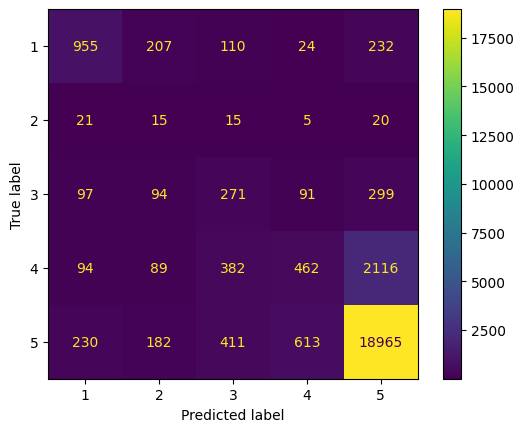

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)

plt.show()

In [43]:
import random

# Define the number of random rows to view
n = 5

# Get random indices from the test set
random_idx = round(random.random() * n_test)


# Retrieve the corresponding sample and its information
sample_text = trunc[n_train:].iloc[random_idx]['review_body']
sample_tokenized = [w for w in cleanly_tokenize(sample_text) if w in words]
sample_real_stars = y_test.iloc[random_idx] 
sample_predicted_stars = predictions[random_idx]  
# sample_is_verified = trunc.iloc[X_test.index[random_idx]]['verified_purchase'] == 'Y'

# Print the sample information
print("Sample Text:", sample_text)
print("Tokenized Text:", sample_tokenized)
print("Real Stars:", sample_real_stars)
print("Predicted Stars:", sample_predicted_stars)

Sample Text: Put these in the license plate of '15 Outback. Looks good. You may need to flip these bulbs around if they don't light up due to polarity of the connectors.
Tokenized Text: ['put', 'license', 'plate', 'outback', 'look', 'good', 'may', 'need', 'flip', 'bulb', 'around', 'not light', 'due', 'polarity', 'connector']
Real Stars: positive
Predicted Stars: negative


In [ ]:
X_test.index[random_idx]

5257

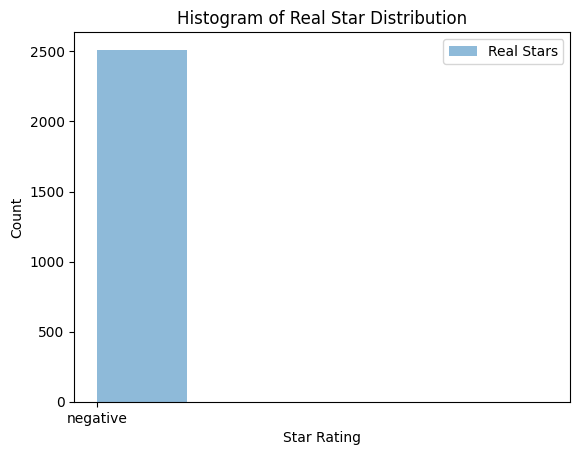

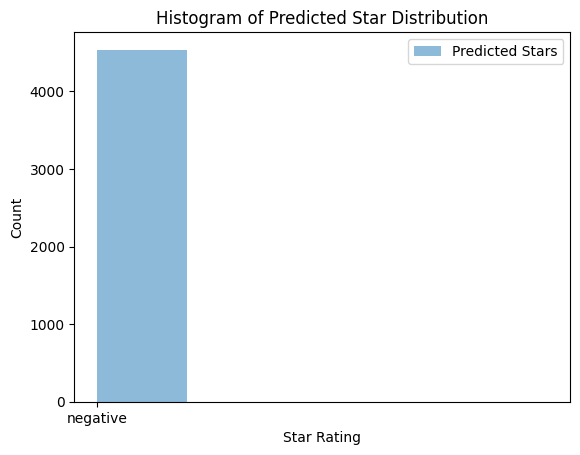

In [44]:
# Plot the histogram of real star distribution
plt.hist(y_test, bins=5, range=(1, 6), alpha=0.5, label='Real Stars')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Histogram of Real Star Distribution')
plt.legend()
plt.show()

# Plot the histogram of predicted star distribution
plt.hist(predictions, bins=5, range=(1, 6), alpha=0.5, label='Predicted Stars')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Histogram of Predicted Star Distribution')
plt.legend()
plt.show()


In [ ]:
stars = data['star_rating']
print(len(stars.loc[stars == 1]))
print(len(stars.loc[stars == 2]))
print(len(stars.loc[stars == 3]))
print(len(stars.loc[stars == 4]))
print(len(stars.loc[stars == 5]))

40807
18588
30140
65431
324838


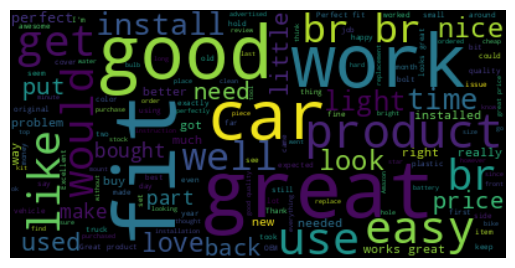

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

textt = " ".join(review for review in trunc['review_body'])
wordcloud = WordCloud(stopwords=stopwords.words()).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
print(stopwords)

<WordListCorpusReader in 'C:\\Users\\Qcoret\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>


In [ ]:
def readFile(fileName):
  #Reads the file, the proper encoding is to prevent problems
  return pd.read_csv(fileName, encoding="utf−8")

In [ ]:
punctuation = string.punctuation

def cleanData(data):
  #Replace missing data with "" in product_title
  data["product_title"] = data["product_title"].fillna("")

  n = len(data["review_body"])
  #for i in np.arange(n):
  #  data["review_body"][i] = BeautifulSoup(data["review_body"][i], "html.parser")

  #Remove the capital letters to prevent miscounting the frequency of words
  data["review_body"] = data["review_body"].str.lower()

  #Remove punctuation so that we can later split the data properly into words by only consider spaces
  data["review_body"] = data["review_body"].apply(lambda data: removePunctuation(data))

  testData = data["review_body"][0:100]
 
  stopwords = set(stopwords.words("english"))
  doc_string = testData.loc[0, "text"]
  print(doc_string)
  


def removePunctuation(text):
    return text.translate(str.maketrans('', '', punctuation))


In [ ]:
def main():
  file = readFile("group_8_automotive_data.csv")
  #print(file.head())

  #Results below show that approximately all data is inserted,
  #except for product_title where approximately 0.0015% is missing
  #print(file.isnull().mean())

  #All variables are intepreted as 'object', except for 'customer_id' and 'star_rating' which are seen as 'int64'. This is fine if we consider the data

  #print(file.dtypes)

  #print(file.min())
  #print(file.max())


  cleanData(file)

main()

UnboundLocalError: local variable 'stopwords' referenced before assignment